In [2]:
import json 
import pandas as pd
from sklearn.model_selection import train_test_split
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_json('transactionsjson.json',lines=True)

In [22]:
#select relevant columns
df = df[[
     'creditLimit', 'availableMoney', 'transactionAmount',
    'transactionType', 'currentBalance', 'posEntryMode', 'cardPresent',
    'expirationDateKeyInMatch', 'isFraud', 'acqCountry', 'merchantCountryCode',
    'posConditionCode', 'transactionDateTime', 'merchantName',
    'accountOpenDate', 'dateOfLastAddressChange'
]]

In [23]:
#split data 

X = df.drop('isFraud', axis=1)
y = df.isFraud

In [24]:
#Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123,)

In [25]:
es = ft.EntitySet(id="transactionData")

In [26]:
#create entity set containing dataframes and relationships

from featuretools import variable_types as vtypes
#variable_types = {
    
  #  'availableMoney': vtypes.Numeric, 
  #  'transactionAmount': vtypes.Numeric,
  #  'currentBalance':vtypes.Numeric,
  #  }

es.entity_from_dataframe(entity_id='transactions',dataframe=X_train,
                      index='index', )


C:\ProgramData\Anaconda3\lib\site-packages\featuretools\entityset\entity.py:611: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: transactionData
  Entities:
    transactions [Rows: 550454, Columns: 16]
  Relationships:
    No relationships

In [27]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="transactionAmounts",
                         index="transactionAmount", )

In [28]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="transactionTypes",
                         index="transactionType", copy_variables=['creditLimit',"merchantName","availableMoney","currentBalance"])

In [29]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="merchant",
                         index="merchantName")

In [30]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="creditLimit",
                         index="creditLimit")

In [31]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="availableMoney",
                         index="availableMoney")

In [32]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="currentBalance",
                         index="currentBalance")

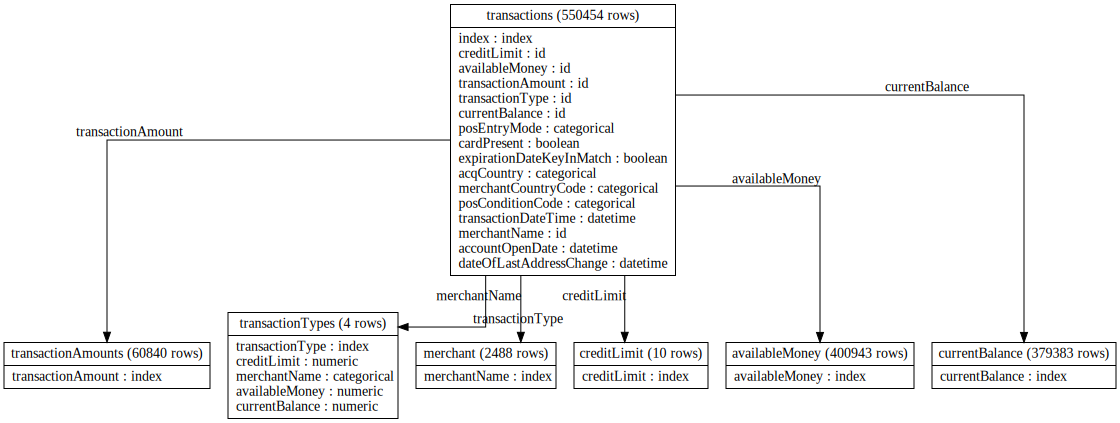

In [33]:
es.plot()

In [38]:
#create features from entityset
feature_matrix,feature_names = ft.dfs(entityset = es, target_entity = 'transactions',
                       
                       features_only=False,verbose=True,n_jobs = 6)

feature_matrix.head()

Built 154 features
EntitySet scattered to 6 workers in 40 seconds                                 
Elapsed: 16:15 | Progress: 100%|███████████████████████████████████████████████


,creditLimit,availableMoney,transactionAmount,transactionType,currentBalance,posEntryMode,cardPresent,expirationDateKeyInMatch,acqCountry,merchantCountryCode,...,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.creditLimit),currentBalance.NUM_UNIQUE(transactions.merchantCountryCode),currentBalance.NUM_UNIQUE(transactions.merchantName),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionAmount),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,2500,1976.74,60.98,PURCHASE,523.26,09,False,False,US,US,...,1.0,1,1,1,1,1,1.0,1,0.000000,0.000000
1,250,250.00,90.93,PURCHASE,0.00,02,True,False,US,US,...,10.0,10,5,2079,4,6,14613.0,4,0.445497,0.001274
2,20000,18632.07,261.07,PURCHASE,1367.93,02,False,False,US,US,...,2.0,2,1,2,1,2,2.0,1,0.000000,0.000000
3,5000,1585.14,110.60,PURCHASE,3414.86,02,True,False,US,US,...,1.0,1,1,1,1,1,1.0,1,1.000000,0.000000
4,5000,558.90,4.87,PURCHASE,4441.10,05,True,False,US,US,...,2.0,2,1,4,1,2,4.0,1,0.750000,0.000000


In [39]:
#Trim irrelevant features
from featuretools.selection import (
    remove_highly_correlated_features,
    remove_highly_null_features,
    remove_single_value_features,
)
new_fm, new_features = remove_single_value_features(feature_matrix, features=feature_names)

In [40]:
ft.selection.remove_highly_null_features(new_fm, features=feature_names)

(        creditLimit  availableMoney  transactionAmount transactionType  \
 index                                                                    
 0              2500         1976.74              60.98        PURCHASE   
 1               250          250.00              90.93        PURCHASE   
 2             20000        18632.07             261.07        PURCHASE   
 3              5000         1585.14             110.60        PURCHASE   
 4              5000          558.90               4.87        PURCHASE   
 ...             ...             ...                ...             ...   
 550449         1000          510.48             360.11        PURCHASE   
 550450        15000        14994.57             114.76        PURCHASE   
 550451        15000        11477.87               8.46        PURCHASE   
 550452        15000        15000.00               9.95        PURCHASE   
 550453        50000        39755.61             329.32        PURCHASE   
 
         currentBalance

In [41]:
ft.selection.remove_low_information_features(new_fm)

,creditLimit,availableMoney,transactionAmount,transactionType,currentBalance,posEntryMode,cardPresent,expirationDateKeyInMatch,acqCountry,merchantCountryCode,...,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.creditLimit),currentBalance.NUM_UNIQUE(transactions.merchantCountryCode),currentBalance.NUM_UNIQUE(transactions.merchantName),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionAmount),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,2500,1976.74,60.98,PURCHASE,523.26,09,False,False,US,US,...,1.0,1,1,1,1,1,1.0,1,0.000000,0.000000
1,250,250.00,90.93,PURCHASE,0.00,02,True,False,US,US,...,10.0,10,5,2079,4,6,14613.0,4,0.445497,0.001274
2,20000,18632.07,261.07,PURCHASE,1367.93,02,False,False,US,US,...,2.0,2,1,2,1,2,2.0,1,0.000000,0.000000
3,5000,1585.14,110.60,PURCHASE,3414.86,02,True,False,US,US,...,1.0,1,1,1,1,1,1.0,1,1.000000,0.000000
4,5000,558.90,4.87,PURCHASE,4441.10,05,True,False,US,US,...,2.0,2,1,4,1,2,4.0,1,0.750000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550449,1000,510.48,360.11,PURCHASE,489.52,05,False,False,US,US,...,1.0,1,1,1,1,1,1.0,1,0.000000,0.000000
550450,15000,14994.57,114.76,PURCHASE,5.43,09,False,False,US,US,...,2.0,2,1,3,2,2,3.0,1,0.333333,0.000000
550451,15000,11477.87,8.46,PURCHASE,3522.13,09,True,False,US,US,...,1.0,1,1,1,1,1,1.0,1,1.000000,0.000000


In [42]:
new_fm, new_features = remove_highly_correlated_features(new_fm, features=feature_names)

In [43]:
#one hot encode features
feature_matrix_enc, features_enc = ft.encode_features(new_fm, new_features, include_unknown=False)

In [44]:
feature_matrix_enc.head()

,creditLimit = 5000,creditLimit = 15000,creditLimit = 7500,creditLimit = 2500,creditLimit = 20000,creditLimit = 10000,creditLimit = 50000,creditLimit = 1000,creditLimit = 250,creditLimit = 500,...,currentBalance.MODE(transactions.transactionType) = PURCHASE,currentBalance.MODE(transactions.transactionType) = ADDRESS_VERIFICATION,currentBalance.MODE(transactions.transactionType) = REVERSAL,currentBalance.MODE(transactions.transactionType) =,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,0.000000,0.000000
1,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,10.0,4,6,4,0.445497,0.001274
2,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,2.0,1,2,1,0.000000,0.000000
3,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,1.000000,0.000000
4,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,2.0,1,2,1,0.750000,0.000000


In [54]:
#copy in feature matrix to X_train 
X_train = feature_matrix_enc.copy()

In [55]:
#save endoded feature table for later use
feature_matrix_enc.to_csv('autofeatures encoded train.csv')

In [56]:
import os
filepath = os.path.join('autofeatures encoded train.json')
ft.save_features(features_enc, filepath)

In [45]:
#Repeat process but now for X_test data.  
#You can load the previously generated features after setting up the identical entityset.

es_test = ft.EntitySet(id="transactionDataTest")

In [46]:
es_test.entity_from_dataframe(entity_id='transactions',dataframe=X_test,
                      index='index', )


C:\ProgramData\Anaconda3\lib\site-packages\featuretools\entityset\entity.py:611: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: transactionDataTest
  Entities:
    transactions [Rows: 235909, Columns: 16]
  Relationships:
    No relationships

In [47]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="transactionAmounts",
                         index="transactionAmount", )

In [48]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="transactionTypes",
                         index="transactionType", copy_variables=['creditLimit',"merchantName","availableMoney","currentBalance"])

In [49]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="merchant",
                         index="merchantName")

In [50]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="creditLimit",
                         index="creditLimit")

In [51]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="availableMoney",
                         index="availableMoney")

In [52]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="currentBalance",
                         index="currentBalance")

In [57]:
#use previouslt generated feature list(features_enc) to calculate new features on test data
feature_matrix_test = ft.calculate_feature_matrix(entityset=es_test, features= features_enc,n_jobs=6)

EntitySet scattered to 6 workers in 30 seconds


In [58]:
feature_matrix_test.head()

,creditLimit = 5000,creditLimit = 15000,creditLimit = 7500,creditLimit = 2500,creditLimit = 20000,creditLimit = 10000,creditLimit = 50000,creditLimit = 1000,creditLimit = 250,creditLimit = 500,...,currentBalance.MODE(transactions.transactionType) = PURCHASE,currentBalance.MODE(transactions.transactionType) = ADDRESS_VERIFICATION,currentBalance.MODE(transactions.transactionType) = REVERSAL,currentBalance.MODE(transactions.transactionType) =,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,1.0,1,1,1,1.0,0.0
1,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,0.0,0.0
2,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,1.0,0.0
3,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,0.0,0.0
4,False,False,True,False,False,False,False,False,False,False,...,False,False,True,False,1.0,1,1,1,0.0,0.0


In [59]:
#copy in feature matrix to X_test
X_test = feature_matrix_test.copy()

In [60]:
#replace true/fasle with 1 and 0 for model
X_train.replace(True,1)
X_train.replace(False,0)

,creditLimit = 5000,creditLimit = 15000,creditLimit = 7500,creditLimit = 2500,creditLimit = 20000,creditLimit = 10000,creditLimit = 50000,creditLimit = 1000,creditLimit = 250,creditLimit = 500,...,currentBalance.MODE(transactions.transactionType) = PURCHASE,currentBalance.MODE(transactions.transactionType) = ADDRESS_VERIFICATION,currentBalance.MODE(transactions.transactionType) = REVERSAL,currentBalance.MODE(transactions.transactionType) =,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,10.0,4,6,4,0.445497,0.001274
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,1,2,1,0.000000,0.000000
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,1.000000,0.000000
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,1,2,1,0.750000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,0.000000,0.000000
550450,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,2,2,1,0.333333,0.000000
550451,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,1.000000,0.000000


In [61]:
X_test.replace(True,1)
X_test.replace(False,0)

,creditLimit = 5000,creditLimit = 15000,creditLimit = 7500,creditLimit = 2500,creditLimit = 20000,creditLimit = 10000,creditLimit = 50000,creditLimit = 1000,creditLimit = 250,creditLimit = 500,...,currentBalance.MODE(transactions.transactionType) = PURCHASE,currentBalance.MODE(transactions.transactionType) = ADDRESS_VERIFICATION,currentBalance.MODE(transactions.transactionType) = REVERSAL,currentBalance.MODE(transactions.transactionType) =,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,1,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235904,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,0.0,0.0
235905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1,1,1,0.0,0.0
235906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,2,2,1,1.0,0.0


In [19]:
#Run XGBClassifier with newly generated features.

In [62]:
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,classification_report, confusion_matrix
import xgboost as xgb

xgbcl = xgb.XGBClassifier(objective='binary:logistic',
                         tree_method='gpu_hist')

# Fit the classifier to the training set
xgbcl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [63]:
y_pred = xgbcl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(y_pred==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.984176


In [64]:
#print confusion matrix, classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[232120     55]
 [  3678     56]]
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    232175
        True       0.50      0.01      0.03      3734

    accuracy                           0.98    235909
   macro avg       0.74      0.51      0.51    235909
weighted avg       0.98      0.98      0.98    235909



In [66]:
#get area under curve (AUC) 
dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params = {"objective":"binary:logistic",'tree_method':'gpu_hist'}
#Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, 
                    nfold=5, num_boost_round=20, 
                    metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.740313       0.004198       0.735786      0.005974
1         0.752078       0.002791       0.747572      0.007568
2         0.757218       0.002605       0.752321      0.006141
3         0.763152       0.001604       0.757553      0.006248
4         0.767171       0.001095       0.759476      0.006289
5         0.772422       0.001796       0.763644      0.005343
6         0.775651       0.001942       0.765988      0.005498
7         0.777439       0.001359       0.766905      0.005480
8         0.779855       0.002282       0.769404      0.006200
9         0.782105       0.002099       0.770258      0.006347
10        0.785262       0.001155       0.772680      0.005898
11        0.788851       0.000830       0.774100      0.005259
12        0.792516       0.001035       0.776541      0.005401
13        0.796007       0.000358       0.778048      0.006089
14        0.798955       0.001026       0.780418      0

In [67]:
dmatrix = xgb.DMatrix(data=X_test, label=y_test)
params = {"objective":"binary:logistic",'tree_method':'gpu_hist'}
#Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, 
                    nfold=5, num_boost_round=20, 
                    metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.711607       0.003301       0.706029      0.011743
1         0.727108       0.008610       0.720389      0.016643
2         0.734340       0.005880       0.726673      0.014317
3         0.745755       0.008506       0.733731      0.016829
4         0.757106       0.005073       0.741079      0.016853
5         0.770493       0.004522       0.751595      0.011695
6         0.777521       0.005580       0.755314      0.010085
7         0.783306       0.004225       0.758284      0.009478
8         0.787710       0.004428       0.758362      0.009453
9         0.792660       0.003437       0.761696      0.009888
10        0.796803       0.004540       0.762659      0.010046
11        0.801888       0.003071       0.765027      0.010679
12        0.808100       0.004818       0.768810      0.007379
13        0.811793       0.004562       0.770375      0.006889
14        0.816728       0.004017       0.772136      0

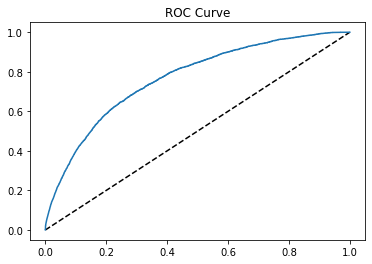

In [70]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = xgbcl.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.show()

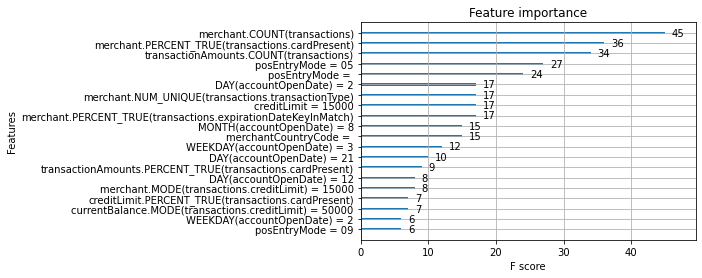

In [68]:
#What are the most important features in the dataset relating to fraud.  
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Create the parameter dictionary: params
params = {"objective":"binary:logistic",'tree_method':'gpu_hist'}

# Train the model: 
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg,max_num_features = 20)
plt.show()


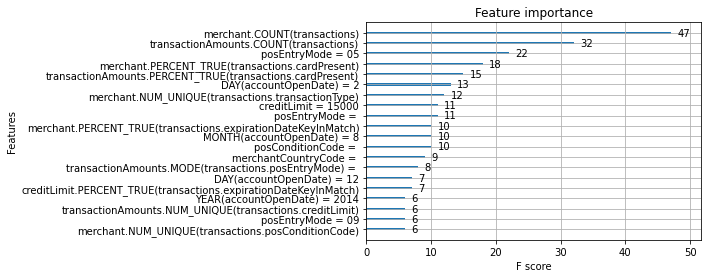

In [69]:
#What are the most important features in the dataset relating to fraud.  
dmatrix = xgb.DMatrix(data=X_test, label=y_test)

# Create the parameter dictionary: params
params = {"objective":"binary:logistic",'tree_method':'gpu_hist'}

# Train the model: 
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg,max_num_features = 20)
plt.show()